## Adaboost on BOW features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

import sys
import numpy as np
sys.path.append('../scripts')
import datasets

#### Cluster definition and Initialization

In [2]:
from ipyparallel import Client
client = Client()
lb_view = client.load_balanced_view()

In [3]:
len(client)

145

#### Model definition

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rndf=RandomForestClassifier(n_estimators=15,n_jobs=1,random_state=4,warm_start=True)
model = AdaBoostClassifier(base_estimator=rndf,random_state=4)
model_keyword='bow_adaboost'
parameters = {
    "base_estimator__max_depth": [5, None],
    "base_estimator__max_features": ["sqrt","log2",None],
    "n_estimators":[10,50],
    "learning_rate":np.logspace(-1,2,4),
}


In [5]:
from mmap_utils import persist_cv_splits
from sklearn.preprocessing import StandardScaler

data=datasets.load_cifar_bow()
scaler = StandardScaler()
X_train = scaler.fit_transform(data.X_train)
X_test = scaler.transform(data.X_test)
Y_train= data.y_train
Y_test= data.y_test

adboost_split_filenames = persist_cv_splits(X_train, Y_train,
    name=model_keyword, random_state=4)

In [6]:
import model_selection
search = model_selection.RandomizedGridSeach(lb_view)
search.launch_for_splits(model, parameters, adboost_split_filenames)

Progress: 00% (000/144)

In [9]:
#search.abort()
#lb_view.aboirt()

In [12]:
print(search.report())

Progress: 100% (144/144)

Rank 1: validation: 0.27173 (+/-0.00069) train: 0.40913 (+/-0.00100):
 {'n_estimators': 50, 'learning_rate': 1.0, 'base_estimator__max_depth': 5, 'base_estimator__max_features': 'sqrt'}
Rank 2: validation: 0.27091 (+/-0.00279) train: 0.32620 (+/-0.00083):
 {'n_estimators': 50, 'learning_rate': 0.10000000000000001, 'base_estimator__max_depth': 5, 'base_estimator__max_features': None}
Rank 3: validation: 0.27064 (+/-0.00217) train: 0.31826 (+/-0.00143):
 {'n_estimators': 50, 'learning_rate': 0.10000000000000001, 'base_estimator__max_depth': 5, 'base_estimator__max_features': 'sqrt'}
Rank 4: validation: 0.27051 (+/-0.00079) train: 0.33194 (+/-0.00053):
 {'n_estimators': 10, 'learning_rate': 1.0, 'base_estimator__max_depth': 5, 'base_estimator__max_features': 'sqrt'}
Rank 5: validation: 0.26917 (+/-0.00128) train: 0.41462 (+/-0.00039):
 {'n_estimators': 50, 'learning_rate': 1.0, 'base_estimator__max_depth': 5, 'base_estimator__max_features': None}


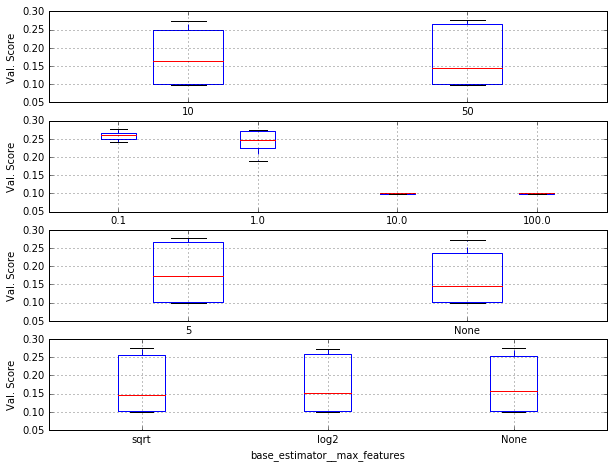

In [13]:
search.boxplot_parameters(display_train=False)

In [14]:
modfile='../models/'+model_keyword+'.pkl'
params=search.find_bests(1)[0][-1]
params

{'base_estimator__max_depth': 5,
 'base_estimator__max_features': 'sqrt',
 'learning_rate': 1.0,
 'n_estimators': 50}

In [15]:
#lb_view.abort()

In [16]:
# mod=search.save_best_model(X_train,Y_train,modfile)
def save_model(model,params,X_train,Y_train):
    model.set_params(**params)
    l=model.fit(X_train,Y_train)
    return l

In [17]:
mod=save_model(model,search.find_bests(1)[0][-1],X_train,Y_train)

In [18]:
#from sklearn.externals import joblib
#joblib.dump(mod,modfile)

In [19]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Y_pred=mod.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
print 'Performance on Test set: %0.2f'% (accuracy_score(Y_test,Y_pred))

Performance on Test set: 0.10


Classification Statistics:
             precision    recall  f1-score   support

   airplane       0.10      0.10      0.10      1005
 automobile       0.09      0.10      0.09       974
       bird       0.10      0.08      0.09      1032
        cat       0.10      0.08      0.09      1016
       deer       0.11      0.10      0.10       999
        dog       0.08      0.10      0.09       937
       frog       0.11      0.11      0.11      1030
      horse       0.11      0.11      0.11      1001
       ship       0.10      0.11      0.10      1025
      truck       0.09      0.10      0.09       981

avg / total       0.10      0.10      0.10     10000



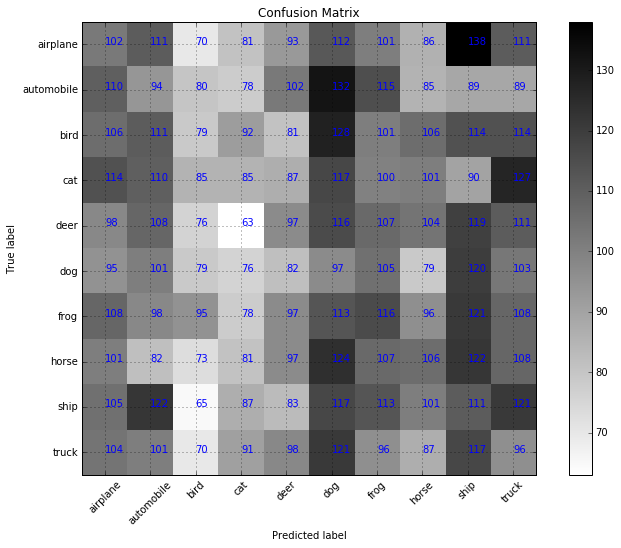

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print 'Classification Statistics:'
print classification_report(Y_test,Y_pred,target_names=classes)

conf = confusion_matrix(Y_test, Y_pred)
plt.imshow(conf, cmap='binary',interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45);plt.yticks(tick_marks, classes)
plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')
font = {'color':  'blue','stretch':'extra-expanded','weight':0,'size': 10}
for i,j in [(n,m) for n in range(len(classes)) for m in range(len(classes))]:
    plt.text(j,i,str(conf[i,j]),font)
